# 4. Model Selection
***

To recap, so far we have read in our data, cleaned our data, and engineered some new features. We have broken out our future training data in three ways: 

 - *Joke Text*
 - *Comment Text*
 - *Joke and Comment Text*

In this notebook, we will focus on some **additional pre-processing steps** that will aid us in model selection. We will also **iteratively build and score models** to select the best performer. We'll then test our NLP model against a more traditional Logistic Regression model using a significantly simpler set of features. Finally, we will take some time to explore our results to understand what differentiates r/DadJokes from r/Jokes in the eyes of a model.
**Executive Summary**
 - [Word Lemmatization](#Build-Lemmatized-Feature-Set)
 - [Model Setup](#Model-Setup)
 - [Vectorization and Model Building](#Vectorization-and-Model-Building)
 - [Model Evaluation](#Model-Evaluation)
 - [Alternative Non-NLP Model](#Alternative-Non-NLP-Model)
 - [Differentiating Features](#Differentiating-Features)

### Libraries

In [599]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import time
import requests
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB


In [560]:
#Read in our latest dataset
jokes_df = pd.read_csv('./datasets/jokesclean.csv')

In [561]:
#Some of the empty text values are rendered as NaN values when read in. Let's correct this before moving forward
jokes_df = jokes_df.fillna('')

### Build Lemmatized Feature Set

One thing we'll be testing in our models is the effectiveness of **lemmatizing** our text. This involves reducing our words to their base forms-- that is, eliminating inflections of words (snowed vs snow, for example). In the below section, we will follow this general process across jokes, comments, and jokes and commentx combined:
 - Tokenizer our strings to pull out and build a list of words
 - Apply lemmatization to our list of words, reducing them to root form, and reassemble our text
 - Store the "lemmatized" version of our text into a new column

The code in this section was made possible through the incorporation of concepts taken from **StackOverflow**. Specifically, the tokenization/lemmitization steps were adapted from a number of responses to NLP related questions on their platform.

In [562]:
#First step here is to tokenize our strings. Instatiate a WhiteSpace Tokenizer and Word Lemmatizer to later application
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

In [563]:
#Build a function that takes in a column, and lemmatizes it
def lemmatize(column):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized = column.apply(
            lambda row: list(list(map(lemmatizer.lemmatize,y)) for y in row))
    return lemmatized

In [565]:
#Build new columns that are tokenized versions of the original text
jokes_df['tokenized_joke'] = jokes_df.apply(lambda row: nltk.word_tokenize(row['joke']), axis=1)
jokes_df['tokenized_comment'] = jokes_df.apply(lambda row: nltk.word_tokenize(row['comment_text']), axis=1)
jokes_df['tokenized_full_text'] = jokes_df.apply(lambda row: nltk.word_tokenize(row['full_text']), axis=1)

In [566]:
#Using these new tokenized columns, now apply the lemmatizer, re-join our words 
#and assign our new lemmatized strings to new columns

jokes_df['joke_lemmatized'] = jokes_df['tokenized_joke'].apply(
            lambda row: " ".join(list(list(map(lemmatizer.lemmatize,row)))))
jokes_df['comment_lemmatized'] = jokes_df['tokenized_comment'].apply(
            lambda row: " ".join(list(list(map(lemmatizer.lemmatize,row)))))
jokes_df['full_text_lemmatized'] = jokes_df['tokenized_full_text'].apply(
            lambda row: " ".join(list(list(map(lemmatizer.lemmatize,row)))))

****
# Model Setup

At this point, we're ready to start training and assessing models. We will be iteratively building models with the following inputs. Each combination of data and model will be scored against the training and test sets to asess bias-variance.

**Training Data**
 - Joke Text; Comment Text; Joke AND Comment Text
 - Lemmatized vs Non-Lemmatized Text
 - CountVectorization vs TfidfVecorization
 
**Models**
 - Logistic, Bayesian, RandomForestClassifier, GradientBoostingClassifier, Adaboost, SVM, Kneighbors
 - Model specific Parameter grids
 - CountVector / TfidfVector parameter grids

Before moving forward, we need to make a couple of quick tweaks. The classification here is binary, so we'll translate our *'subreddit'* column to reflect this. We also take a peek at the value counts of our target to understand the **baseline** which is currently at 58%. This will be essential to understanding model performance.

### Train Test Splits


As mentioned before, we have a number of different training data sets to test. Here we'll leverage train_test_split to build our training data sets-- of which there at **6 in total**.

In [567]:
#Separate out our target
y = jokes_df['subreddit']

In [568]:
#Take a look at our baseline to better understand model performance
y.value_counts(normalize=True).round(2)

1    0.58
0    0.42
Name: subreddit, dtype: float64

#### Training Data Variations (No Lemmatization)

In [569]:
#Build training data set for joke text, non-lemmatized
X_joke = jokes_df['joke']
X_train_joke, X_test_joke, y_train, y_test = train_test_split(X_joke,y,test_size=0.33,stratify=y,random_state=42)

#Build training data set for comment text, non-lemmatized
X_comment = jokes_df['comment_text']
X_train_comment, X_test_comment, __, __ = train_test_split(X_comment,y,test_size=0.33,stratify=y,random_state=42)

#Build training data set for ALL text, non-lemmatized
X_fulltext = jokes_df['full_text']
X_train_fulltext, X_test_fulltext, __, __ = train_test_split(X_fulltext,y,test_size=0.33,stratify=y,random_state=42)

#### Training Data Variations (Lemmatization)

In [570]:
#Build training data set for joke text, lemmatized
X_jokes_lem = jokes_df['joke_lemmatized']
X_train_joke_lem, X_test_joke_lem, __, __ = train_test_split(X_jokes_lem,y,test_size=0.33,stratify=y,random_state=42)

#Build training data set for comment text, lemmatized
X_comment_lem = jokes_df['comment_lemmatized']
X_train_comment_lem, X_test_comment_lem, __, __ = train_test_split(X_comment_lem,y,test_size=0.33,stratify=y,random_state=42)

#Build training data set for ALL text, lemmatized
X_fulltext_lem = jokes_df['full_text_lemmatized']
X_train_fulltext_lem, X_test_fulltext_lem, __, __ = train_test_split(X_fulltext_lem,y,test_size=0.33,stratify=y,random_state=42)

****
# <span style="color:black">**Vectorization and Model Building**</span>

Now, with cleaned data, engineered features, and train/test splits prepared, we're ready to move into the modeling phases. Because we're dealing with a number of different model types, we are going to start by constructing **param grids** for our vectorizers (CountVectorizer, TfIdfVectorizer). **Vecorization** of our text data is an essential step in NLP-- it enables us to numerically represent text data. In the case of *CountVectorizer*, each word in our corpus is translated into a feature, and counts the word frequencies. It's a simple representation of our text. In the case of *TfidfVectorizer*, words that occur more frequently are weighted higher in our model; words that do not appear frequently recieve lower weighting. This approach helps to drown out some of the noise in our text data. 

Below, we will build paramater grids for both of these objects to understand what the optimal combination of parameters are. In our case, we'll look at **max features**, **ngram range**, **min_df**, and **stop words**. Max features establishes a cutoff for the number of words presented in our model; n-gram range refers to our ability to couple words together to prevent context from being lost when tokenizing our words; min_df refers to the document-level frequency threshold that needs to be met by a word to be part of our model; stopwords refer to whether or not our model will strip out common english language terms, or keep them in. In the case of the stop words, this is particularly interesting to test for jokes, which can be quite short in length.

In [571]:
#Establish a param grid for our CountVectorizer and Tfidf Vectorizer
vect_params = {
           'cvec': 
                   {
                'vectorizer__max_features': [1200,1500],
                'vectorizer__ngram_range': [(1,1),(1,2)],
                'vectorizer__min_df' : [2,5],
                'vectorizer__stop_words': [None,'english']
                    },
           'tvec': 
                    {
                'vectorizer__max_features': [1200,1500],
                'vectorizer__ngram_range': [(1,1),(1,2)],
                'vectorizer__min_df' : [2,5],
                'vectorizer__stop_words': [None,'english']
                    } 
         }

Next, we will build an additional set of parameter grids for our models. These will vary model to model as the parameters are often different between modeling methods. Things like penaltization (in the case of Logistic Regression, L1 vs L2, for example) will be grid-searched to understand the optimal parameter set. In combination with our vectorizer param grids, this will enable us to fine-tune our models.

In [572]:
model_params = {
            'logistic': 
                   {     
                'model__penalty':['l2','l1'],
                'model__C':[.01,0.1, 1]
                   },
            'mnb': 
                   {     
                   },            
            'random': 
                   { 
                'model__n_estimators': [100, 150, 200],
                'model__max_depth': [None, 2, 4, 6]
                   },
            'adaboost': 
                    {
                 'model__n_estimators': [50, 100, 150, 200],
                 'model__learning_rate': [.1, .5, .9, 1.]
                    },
            'gradient':
                    {
                'model__n_estimators': [100, 150, 200],
                'model__max_depth': [None, 2,3,4],
                'model__learning_rate': [.08, .1, .12]
                    },
            'svc': 
                    {
#                 'model__C': np.logspace(-2, 2, 5),
#                 'model__gamma': np.logspace(-4, 0, 5)
                    },
            'kneighbors': 
                    {
                'model__n_neighbors': [5, 7, 15],
                'model__weights': ['uniform', 'distance']
                    }
               }

The below function will allow us to iteratively build, fit, and score our model variations.

In [573]:
#Build a function to handle X_train data selection, param_grid selection, pipe construction, and scoring
def pipe_fit_score(model, X_type, vect_string='', processing_step=''):
    
    #set pipe params to zero as we will build this over the course of the function
    pipe_params={}

    #################################################
    #Here, we check for the processing_step and X_type arguments to determine which training set we will use
    if ((X_type == 'joke') & (processing_step == 'none')):
        X_train_pipe = X_train_joke
        X_test_pipe = X_test_joke
        
    elif ((X_type == 'comment') & (processing_step == 'none')):
        X_train_pipe = X_train_comment
        X_test_pipe = X_test_comment
        
    elif ((X_type == 'full_text') & (processing_step == 'none')):
        X_train_pipe = X_train_fulltext
        X_test_pipe = X_test_fulltext
        
    elif ((X_type == 'joke') & (processing_step == 'lemmatize')):
        X_train_pipe = X_train_joke_lem
        X_test_pipe = X_test_joke_lem
        
    elif ((X_type == 'comment') & (processing_step == 'lemmatize')):
        X_train_pipe = X_train_comment_lem
        X_test_pipe = X_test_comment_lem
        
    elif ((X_type == 'full_text') & (processing_step == 'lemmatize')):
        X_train_pipe = X_train_fulltext_lem
        X_test_pipe = X_test_fulltext_lem
    else:
        pass
        
    ###############################################  
    #Here, we check vect_string to set up our param grids for vectorization methods
    if vect_string == 'tvec':
        pipe_params = vect_params['tvec'].copy()
        vectorizer = TfidfVectorizer()
    elif vect_string == 'cvec':
        pipe_params = vect_params['cvec'].copy()
        vectorizer = CountVectorizer()
    else:
        pass  
    
   ################################################ 
   #Check the type of the model passed through. Update param grids to reflect model specific params
    if (type(model) == type(LogisticRegression())):
        pipe_params.update(model_params['logistic'])
    elif (type(model) == type(RandomForestClassifier())):
        pipe_params.update(model_params['random'])
    elif (type(model) == type(MultinomialNB())):
        pipe_params.update(model_params['mnb'])    
    elif (type(model) == type(AdaBoostClassifier())):
        pipe_params.update(model_params['adaboost'])    
    elif (type(model) == type(KNeighborsClassifier())):
        pipe_params.update(model_params['kneighbors'])  
    elif (type(model) == type(SVC())):
        pipe_params.update(model_params['svc'])  
    elif (type(model) == type(GradientBoostingClassifier())):
        pipe_params.update(model_params['gradient'])  
    else:
        pass

 
   ################################################   
   #Build pipeline here that we'll pass to GridSearchCV
    pipe = Pipeline([
        ('vectorizer', vectorizer),
        ('model' , model)
    ])
    
    #Build gridsearch object using the parameter grid we constructed
    gs = GridSearchCV(pipe, 
                      pipe_params, 
                      cv=3)
    
    #Fit model and grab the best combination of parameters
    gs.fit(X_train_pipe,y_train)
    gs_model = gs.best_estimator_
    
    #REturn the scores against test and train
    return(gs.best_score_, gs.score(X_test_pipe, y_test), gs_model.get_params)
    

Here, we pass into our function pipe_fit_score all possible combinations for our model builds. We will then take the scores and parameters produced by the function and store it in a dataframe. This will allow us to see all the scores for every combination we produced.

In [574]:
#Build a df that will be home to our model scores and outputs
model_df2 = pd.DataFrame(columns=['model', 'data',
                           'processing', 'vectorizer', 'train_accuracy', 'test_accuracy'])

#Prevent warnings from flooding the screen
with warnings.catch_warnings():
   
    # ignore all caught warnings
    warnings.filterwarnings("ignore")

    #Lists of the varities of inputs/models
    train_types = ['joke','comment','full_text']
    vector_types = ['cvec','tvec']
    processing_steps = ['none','lemmatize']
    model_types = [GradientBoostingClassifier(random_state=42),AdaBoostClassifier(), MultinomialNB(), 
                   RandomForestClassifier(random_state=42), LogisticRegression(), KNeighborsClassifier(), SVC()]

    #Nested for loops will go along each of our lists, producing a model to a temporary dict.
    #That dict is then passed over to our model dataframe
    for model in model_types:
        for processing_step in processing_steps:    
            for train_type in train_types:
                for vector_type in vector_types:
                    
                    model_output = {}
                    model_output['model'] = type(model)
                    model_output['data'] = train_type  
                    model_output['processing'] = processing_step
                    model_output['vectorizer'] = vector_type
                    model_output['train_accuracy'], model_output['test_accuracy'],  model_output['params']= pipe_fit_score(model,train_type,vector_type,processing_step)
                    
                    model_df2 = model_df2.append(model_output, ignore_index=True)


In [580]:
model_df2.to_csv('./datasets/modeloutput.csv', index=False)

***
## Model Evaluation

With our function, we're now able to look across model combinations to find the optimal option for us. Many different model options were tested with varying inputs, so we will read into a DataFrame to assess. WE'll quickly clean up this dataframe slightly -- replacing model names and making sure data types are correct for aggregation.

After that is complete, let's go through each of the below questions and answer them:

- **Did we see any improvements with lemmatized data?** *We hypothesize that, given the nature of jokes (short, simple), lemmatization will not have a significant impact*
- **How does accuracy vary by text source (joke, comment, full text)?** *We hypothesize that more text (i.e. combining jokes and comments) will enhance our model*
- **Which vectorizer approach was best?** *We hypothesize that TfidfVectorizer will outperform the simpler approach of CountVectorizer*
- **Which model produced the strongest accuracy?** We hypothesize that a simpler classification approach will produce better results.

In [581]:
#Let's use the csv in case we need to undo any changes to our df
model_df = pd.read_csv('./datasets/modeloutput.csv')

#Our accuracy scores are reported to be floats but casting them seems to fix an 'ABCMeta' error in our groupby code
model_df['test_accuracy'] = model_df['test_accuracy'].astype('float')
model_df['train_accuracy'] = model_df['train_accuracy'].astype('float')

#Sort our models by test accuracy and assess
model_df.sort_values(by='test_accuracy', ascending=False).head(5)

,model,data,processing,vectorizer,train_accuracy,test_accuracy,params
10,<class 'sklearn.ensemble.gradient_boosting.Gra...,full_text,lemmatize,cvec,0.678821,0.697638,<bound method Pipeline.get_params of Pipeline(...
46,<class 'sklearn.ensemble.forest.RandomForestCl...,full_text,lemmatize,cvec,0.684251,0.696063,<bound method Pipeline.get_params of Pipeline(...
47,<class 'sklearn.ensemble.forest.RandomForestCl...,full_text,lemmatize,tvec,0.698991,0.696063,<bound method Pipeline.get_params of Pipeline(...
11,<class 'sklearn.ensemble.gradient_boosting.Gra...,full_text,lemmatize,tvec,0.677269,0.694488,<bound method Pipeline.get_params of Pipeline(...
22,<class 'sklearn.ensemble.weight_boosting.AdaBo...,full_text,lemmatize,cvec,0.673390,0.694488,<bound method Pipeline.get_params of Pipeline(...


In [582]:
#Make model type easier to read in our dataframe
model_df.loc[(model_df['model'] == '<class \'sklearn.ensemble.forest.RandomForestClassifier\'>'), 'model'] = 'RandomForest'
model_df.loc[model_df['model'] == '<class \'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier\'>', 'model'] = 'GradientBoost'
model_df.loc[model_df['model'] == '<class \'sklearn.ensemble.weight_boosting.AdaBoostClassifier\'>', 'model'] = 'AdaBoost'
model_df.loc[model_df['model'] == '<class \'sklearn.linear_model.logistic.LogisticRegression\'>', 'model'] = 'LogisticReg'
model_df.loc[model_df['model'] == '<class \'sklearn.naive_bayes.MultinomialNB\'>', 'model'] = 'MultinomialNB'
model_df.loc[model_df['model'] == '<class \'sklearn.neighbors.classification.KNeighborsClassifier\'>', 'model'] = 'KNeighbors'
model_df.loc[model_df['model'] == '<class \'sklearn.svm.classes.SVC\'>', 'model'] = 'SVC'
model_df['abs_diff'] = abs(model_df['test_accuracy'] - model_df['train_accuracy'])

#### *Question: Did we see any improvements with lemmatized data?*


Looking across our models, there is very little difference in lemmatized vs non-lemmatized data with respect to our training or test data. One theory here as to why this is the case is because we are dealing with joke text data, and corresponding comments which are often joke-related. In these cases, we may be dealing with a very basic vocabulary for the overall corpus, which would mean that lemmatization would have a neglible impact on the accurayc of our model.

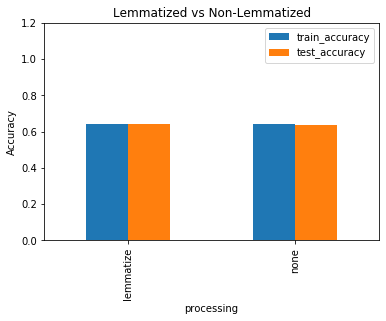

In [644]:
#Check our average train and test accuracy scores based on Lemmatization vs Non-Lemmatization
model_df.groupby('processing')[['train_accuracy','test_accuracy']].mean().plot(kind='bar', ylim=(0,1.2), title='Lemmatized vs Non-Lemmatized');
plt.ylabel('Accuracy');


In [584]:
#print the values
model_df.groupby('processing')[['train_accuracy','test_accuracy', 'abs_diff']].mean().round(3)

,train_accuracy,test_accuracy,abs_diff
processing,,,
lemmatize,0.641,0.640,0.011
none,0.641,0.637,0.008


#### *Question: How did accuracy vary by text source?*


Here we see some real differentiation across test cells. Our accuracy scores are substantially worse (and only marginally better than our benchmark) when looking at comments only. **Full text** training data appears to be the top performer here, with Joke text data in a close second. Also interesting here to note - Joke text data saw more variance across models. The combination of the two boosted accuracy while also reducing variance, suggesting that our model was potentially starved for data when isolating.

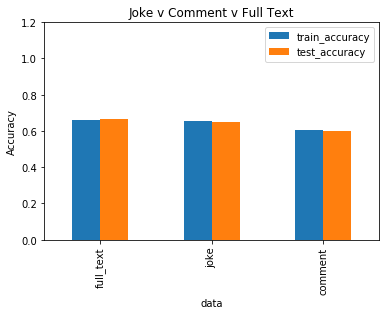

In [643]:
#Plot average train and test accuracy scores based on Joke, Comment, Full Text
model_df.groupby('data')[['train_accuracy','test_accuracy']].mean().sort_values(by='test_accuracy', ascending=False).plot(kind='bar', ylim=(0,1.2),title='Joke v Comment v Full Text');
plt.ylabel('Accuracy');

In [586]:
#Check our average train and test accuracy scores based on Joke, Comment, Full Text
model_df.groupby('data')[['train_accuracy','test_accuracy', 'abs_diff']].mean().round(3)

,train_accuracy,test_accuracy,abs_diff
data,,,
comment,0.606,0.602,0.009
full_text,0.661,0.666,0.009
joke,0.657,0.648,0.011


#### *Question: Which Vectorizer did best?*


While accuracy scores are close across vectorizers, our **CountVectorizer** treatment models have the slight edge in terms of accuracy score. One theory we have here is that common words are actually helpful in distinguishing between classes. This is something we'll dig into at a deeper level when assessing word alignment between r/Jokes and r/DadJokes.

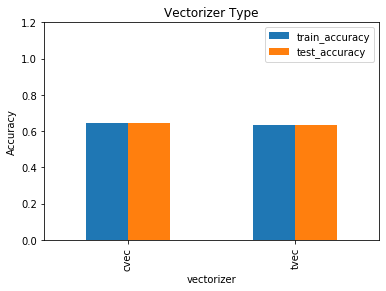

In [642]:
#Plot average train and test accuracy scores based on Cvec v Tvec
model_df.groupby('vectorizer')[['train_accuracy','test_accuracy']].mean().sort_values(by='test_accuracy', ascending=False).plot(kind='bar', ylim=(0,1.2),title='Vectorizer Type');
plt.ylabel('Accuracy');

In [588]:
#Check our average train and test accuracy scores based on CountVec v TfidfVec
model_df.groupby('vectorizer')[['train_accuracy','test_accuracy', 'abs_diff']].mean().round(3)

,train_accuracy,test_accuracy,abs_diff
vectorizer,,,
cvec,0.647,0.644,0.01
tvec,0.636,0.633,0.01


#### *Question: Which model produced the strongest accuracy score?*


Here we start to see some real variation in performance. Two caveats that needs to be addressed before proceeding in this section:
 - We are looking at cross-validated averages for our train accuracy. In some cases, like Random Forest, breaking about this cross validation score reveals significant variation. While not visualized here, it's important to note
 - With more time, we would test additional parameter tuning. This performance is a reflection of the ranges we provided to GridSearch
 
In terms of performance across all of our test cells, **Gradient Boost, Logistic Regression, and RandomForest** appear to be top performers in both test accuracy but also variance. Scores are relatively close across the board but there is noticeable dropoff in accuracy when assessing KNeighbors and SVC. With more time, we'd dig into why this is the case. But for now, with the goal of building a stable model, we'll move forward with these top three approaches and build an **Ensemble** model. 

You can also see the individual model performance in the below table.

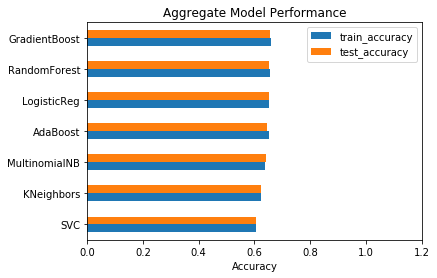

In [799]:
#Check our average train and test accuracy scores based on Model
model_df.groupby('model')[['train_accuracy', 'test_accuracy']].mean().sort_values(by='train_accuracy', ascending=True).plot(kind='barh', xlim=(0,1.2),title='Aggregate Model Performance');
plt.xlabel('Accuracy');
plt.ylabel('');

In [771]:
model_df.groupby('model')[['train_accuracy','test_accuracy', 'abs_diff']].mean().sort_values(by='train_accuracy', ascending=False).round(3)

,train_accuracy,test_accuracy,abs_diff
model,,,
GradientBoost,0.658,0.656,0.011
RandomForest,0.657,0.650,0.009
LogisticReg,0.653,0.650,0.009
AdaBoost,0.653,0.645,0.014
MultinomialNB,0.637,0.642,0.009
KNeighbors,0.625,0.622,0.013
SVC,0.607,0.604,0.003


In [654]:
model_df[['data','processing','vectorizer','model','train_accuracy','test_accuracy', 'abs_diff']].sort_values(by='test_accuracy', ascending=False).round(3).head(25)

,data,processing,vectorizer,model,train_accuracy,test_accuracy,abs_diff
10,full_text,lemmatize,cvec,GradientBoost,0.679,0.698,0.019
46,full_text,lemmatize,cvec,RandomForest,0.684,0.696,0.012
47,full_text,lemmatize,tvec,RandomForest,0.699,0.696,0.003
11,full_text,lemmatize,tvec,GradientBoost,0.677,0.694,0.017
22,full_text,lemmatize,cvec,AdaBoost,0.673,0.694,0.021
16,full_text,none,cvec,AdaBoost,0.678,0.691,0.013
23,full_text,lemmatize,tvec,AdaBoost,0.687,0.685,0.002
35,full_text,lemmatize,tvec,MultinomialNB,0.656,0.685,0.029
59,full_text,lemmatize,tvec,LogisticReg,0.672,0.683,0.012
52,full_text,none,cvec,LogisticReg,0.694,0.683,0.010


### Yo Dawg, Heard You Like Models...

We're knocking on the door of 70% with our models, but we have not broken it quite yet. We'll now take our top models and inputs and build a **Voting Classifier,** which is a method of ensemble modeling. We'll employ a "hard vote" here-- each model will have a vote on what classification a joke is-- in theory this will help each model correct one another. The alternative is a "soft vote" but this requires calibration at the model level. With more time and exploration this is something we could consider. Let's see if we can push out accuracy further using this approach.

In [673]:
#Vectorizer Winner: CountVectorizer()
#Pre-Processing Winner: Lemmatization
cvec_fulltext_lem_ensemble = CountVectorizer()

cvec_fulltext_lem_ensemble.fit(X_train_fulltext_lem)

X_train_fulltext_lem_ensemble_cvec = cvec_fulltext_lem_ensemble.transform(X_train_fulltext_lem)
X_test_fulltext_lem_ensemble_cvec = cvec_fulltext_lem_ensemble.transform(X_test_fulltext_lem)

In [789]:

#Prevent warnings from flooding the screen
with warnings.catch_warnings():
   
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    
    #Build our VotingClassifer (Oprah Themed) and bring in our top modles based on test accuracy, and low variance. We'll
    #use a mix of RandomForest, GradientBoost, Multinomial, and LogisticRegression
    xzibit = VotingClassifier([
        ('log', LogisticRegression(random_state=42)),
        ('tree',  RandomForestClassifier(random_state=42)),
        ('mnb',  MultinomialNB()),
        ('gb', GradientBoostingClassifier(random_state=42))
    ], )
    xzibit_params = {
#           'gb__n_estimators': [100,150,175],
#           'gb__max_depth': [1,2,3,4],
          'log__penalty':['l2','l1'],
          'log__C':[.01,0.1, 1],  
    }
    gs_xzibit = GridSearchCV(xzibit, param_grid=xzibit_params, cv=3)
    gs_xzibit.fit(X_train_fulltext_lem_ensemble_cvec, y_train)

In [790]:
print(gs_xzibit.best_score_)
gs_xzibit.score(X_test_fulltext_lem_ensemble_cvec, y_test)

0.6873545384018619


0.6976377952755906

Let's break out these models and see what their probability distributions look like. Ideally, their distributions will not overlap.

In [733]:
#Recreate LogRegression model and save probabilities to df
lr = LogisticRegression(random_state=42,penalty='l1',C=0.01)
lr.fit(X_train_fulltext_lem_ensemble_cvec, y_train)
lr_df = pd.DataFrame(lr.predict_proba(X_test_fulltext_lem_ensemble_cvec))

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [732]:
#Recreate GradientBoost model and save probabilities to df
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_fulltext_lem_ensemble_cvec, y_train)
gb_df = pd.DataFrame(gb.predict_proba(X_test_fulltext_lem_ensemble_cvec))

In [751]:
#Recreate RandomForest model and save probabilities to df
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_fulltext_lem_ensemble_cvec, y_train)
rf_df = pd.DataFrame(rf.predict_proba(X_test_fulltext_lem_ensemble_cvec))

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [756]:
#Recreate Multinomial model and save probabilities to df
mnb = MultinomialNB()
mnb.fit(X_train_fulltext_lem_ensemble_cvec, y_train)
mnb_df = pd.DataFrame(mnb.predict_proba(X_test_fulltext_lem_ensemble_cvec))

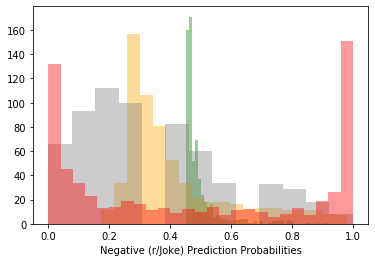

In [802]:
#Bring all probs together into one dataframe and plot distributions
test_df =pd.concat([lr_df,gb_df,rf_df,mnb_df], ignore_index=True, axis=1)
sns.distplot(test_df[0], color='green', kde=False);
sns.distplot(test_df[2], color='orange', kde=False);
sns.distplot(test_df[4], color='gray', kde=False);
sns.distplot(test_df[6], color='red', kde=False, bins=25);
plt.xlabel('Negative (r/Joke) Prediction Probabilities');


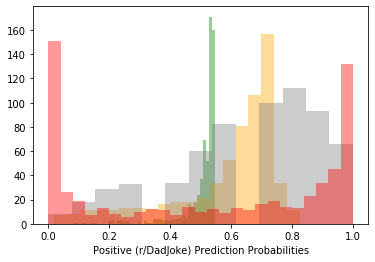

In [801]:
#Bring all probs together into one dataframe and plot distributions
test_df =pd.concat([lr_df,gb_df,rf_df,mnb_df], ignore_index=True, axis=1)
sns.distplot(test_df[1], color='green', kde=False);
sns.distplot(test_df[3], color='orange', kde=False);
sns.distplot(test_df[5], color='gray', kde=False);
sns.distplot(test_df[7], color='red', kde=False, bins=25);
plt.xlabel('Positive (r/DadJoke) Prediction Probabilities');


***
## <span style="color:blue">**Alternative Non-NLP Model**</span>

### Setup

So far, we have leveraged advanced modeling methods to classify whether or not our text is coming from r/Jokes, or r/DadJokes. Now, we will take a step back and take a simpler approach to see if a significantly culled down list of features, and our knowledge of dad joke constructs, can be an effective classification algorithm. To explore this, we'll return to our original data, and pull in the following features:
 - Profanity Flag
 - Pun Flag
 - Joke_Length
 - Num_Comments
 - Setup Dummies ("What do...", "Why do...")

Our hypothesis here is that Dad jokes are clean, often involve puns (recall that we have a list of homophones/homonyms), are shorter in general than normal jokes, and generate less comments than a regular joke. Let's see what we find!

In [618]:
#Isolate for the features we're interested in
X_additional = jokes_df[['profanity','pun','joke_length', 'num_comments','setup_did you',
       'setup_how do', 'setup_what do', 'setup_why do']]

In [619]:
#Bring back our baseline for reference
y.value_counts(normalize=True).round(2)

1    0.58
0    0.42
Name: subreddit, dtype: float64

In [620]:
#Create a new train test split for our new feature set
X_train_add, X_test_add, y_train, y_test = train_test_split(X_additional,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

### Model

In [630]:
#Leverage Logistic Regression ot model features that are not text based
gs_xzibit.fit(X_train_add,y_train)

C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to '

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=VotingClassifier(estimators=[('log',
                                                     LogisticRegression(C=1.0,
                                                                        class_weight=None,
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='warn',
                                                                        n_jobs=None,
                                                                        penalty='l2',
             

In [631]:
print(gs_xzibit.best_score_)
gs_xzibit.score(X_test_add, y_test)

0.6408068269976727


0.7070866141732284